In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install from https://pypi.org/project/matrixprofile/
!pip install -U matrixprofile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 7.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.8 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.8.0 requires protobuf<4,>=3.13, but you have protobuf 3.11.2 which is incompatible.
googleapis-common-protos 1.56.2 requires protobuf<4.0.0dev,>=3.15.0, but you have protobuf 3.11.2 which is incompatible.
google-api-core 1.31.6 requires protobuf<4.0.0dev,>=3.12.0; python_version > "3", but you have protobuf 3.11.2 which is incompatible.


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import matrixprofile as mp
import pandas as pd
import pickle

import seaborn as sns

%matplotlib inline

**DORMS (LOAD) STARTS HERE**

In [26]:
# Read dorms data
df_d=pd.read_excel("drive/My Drive/Data/dorm.xlsx")

In [27]:
# Convert timestamps
df_d["SysDate-ms"]=pd.to_datetime(df_d["SysDate-ms"],format="%m/%d/%Y %H:%M:%S %f")

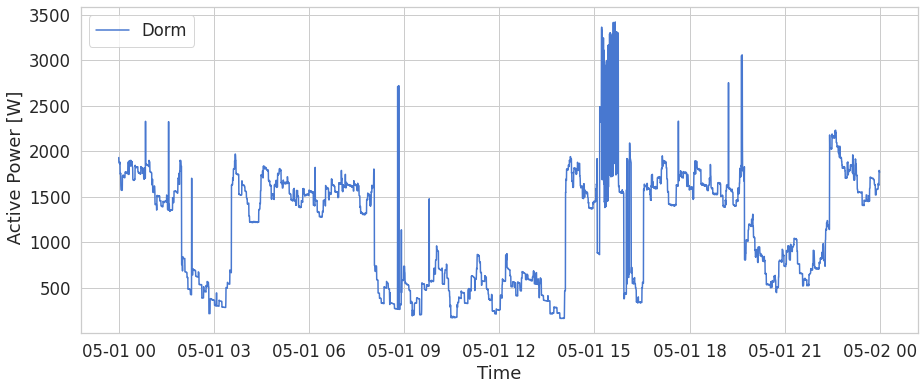

In [28]:
# Basic plot - Dorm

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

plt.figure(figsize=(15, 6))
plt.plot(df_d["SysDate-ms"][::10],df_d["P1"][::10], label="Dorm")
plt.legend(loc='upper left')
plt.ylabel(" Active Power [W]"); plt.xlabel("Time");
plt.savefig('/content/drive/MyDrive/Figures/one_day_dorm.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/matrixprofile/visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/usr/local/lib/python3.7/dist-packages/matrixprofile/visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/usr/local/lib/python3.7/dist-packages/matrixprofile/visualize.py:433: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


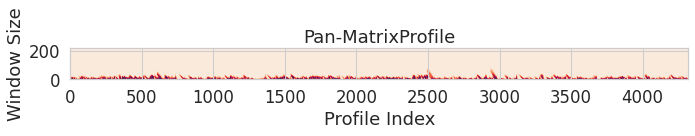

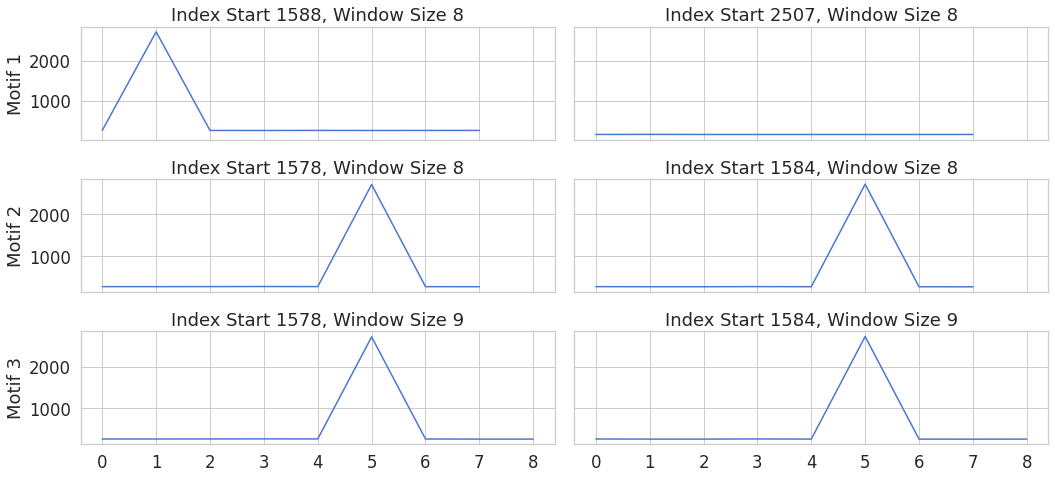

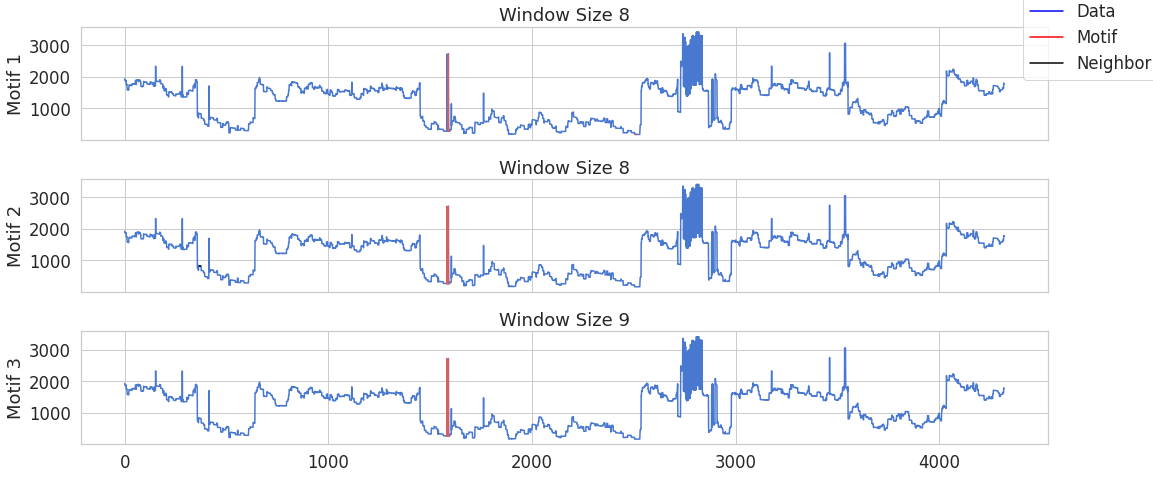

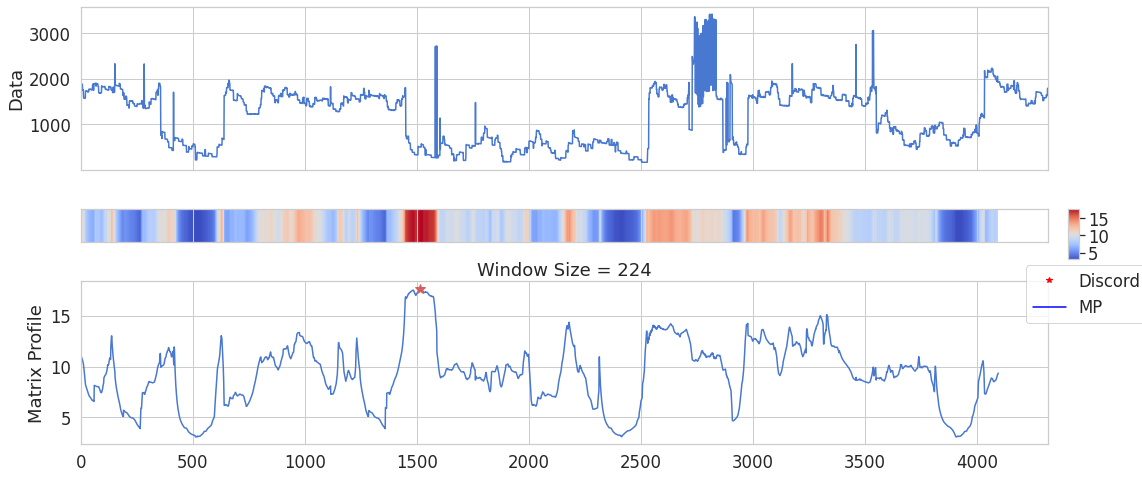

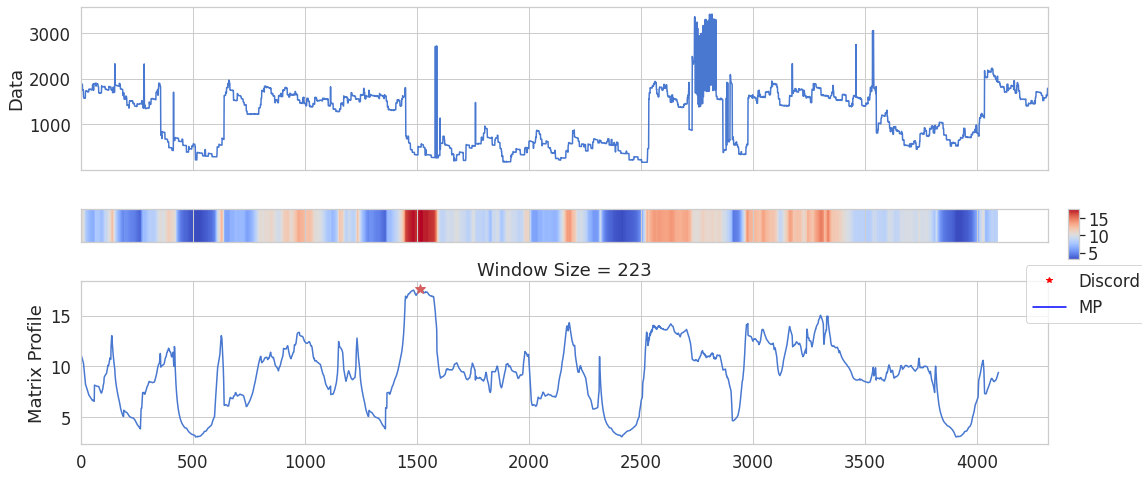

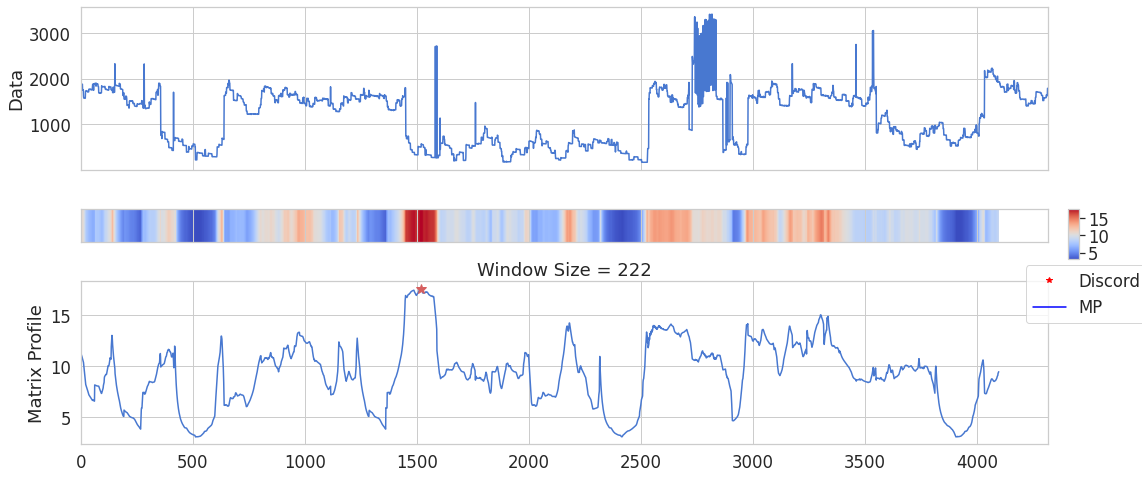

In [ ]:
# Analysis for 1s data (decimated)
profile_d, figures_d = mp.analyze(df_d["P1"][::10].to_numpy())

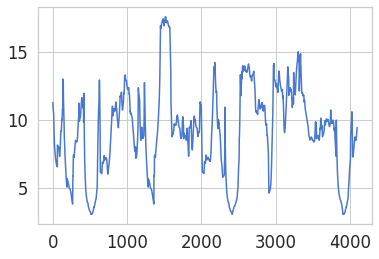

In [30]:
p_d=mp.compute(df_d["P1"][::10].to_numpy(), windows=222)
plt.plot(p_d["mp"])

In [31]:
# Load noise 0-5%
# 2%
noise = np.random.normal(0, 0.02 * (np.std(df_d["P1"])), df_d["P1"].shape)
new_signal = df_d["P1"] + noise
p2_d = mp.compute(new_signal[::10].to_numpy(), windows=222)

# 5%
noise = np.random.normal(0, 0.05 * (np.std(df_d["P1"])), df_d["P1"].shape)
new_signal = df_d["P1"] + noise
p5_d = mp.compute(new_signal[::10].to_numpy(), windows=222)


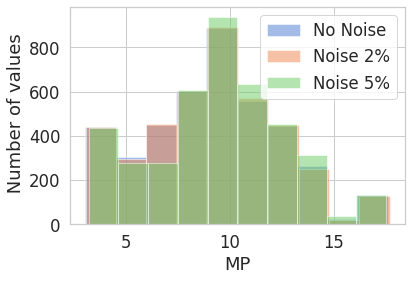

In [45]:
# MP histogram

plt.hist(p_d['mp'],  alpha=0.5, label='No Noise')
plt.hist(p2_d['mp'],  alpha=0.5, label='Noise 2%')
plt.hist(p5_d['mp'], alpha=0.5, label='Noise 5%')
plt.legend(loc='upper right')
plt.ylabel(" Number of values"); plt.xlabel("MP");
plt.savefig('/content/drive/MyDrive/Figures/noisy_hist_d.pdf',format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [33]:
# Create 100 matrix profiles with random noise
# No exclusion zone

profiles_d=[]

for i in range(100):
  noise = np.random.normal(0, np.sqrt(np.mean(df_d["P1"])), df_d["P1"].shape)
  new_signal = df_d["P1"] + noise

  p = mp.compute(new_signal[::10].to_numpy(), windows=222)
  p = mp.discover.discords(p)
  profiles_d.append(p)

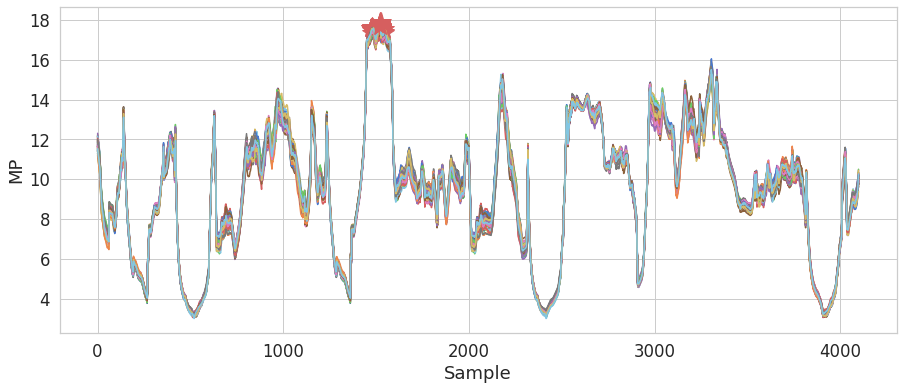

In [34]:
plt.figure(figsize=(15, 6))
for i in range(100):
  plt.plot(profiles_d[i]["mp"])
  x = profiles_d[i]["discords"][0]
  y = profiles_d[i]['mp'][x]
  plt.plot(x, y, marker='*', markersize=20, c='r')

plt.ylabel("MP"); plt.xlabel("Sample");
plt.savefig('/content/drive/MyDrive/Figures/noisy_profiles_dorms.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [35]:
# Basic statistics for MP without and with noise
df_dd = pd.DataFrame()
df_dd["MPd"]=p_d["mp"]

In [36]:
a=profiles_d[0]["mp"]

for i in range(99):
  a=a+profiles_d[i+1]["mp"]

a=a/100
df_dd["MPdn"]=a

In [37]:
df_dd.describe()

,MPd,MPdn
count,4099.000000,4099.000000
mean,9.187756,9.563613
std,3.234979,3.237932
min,3.049278,3.214695
25%,7.087307,7.596656
50%,9.334542,9.804457
75%,11.175564,11.602134
max,17.608105,17.555108


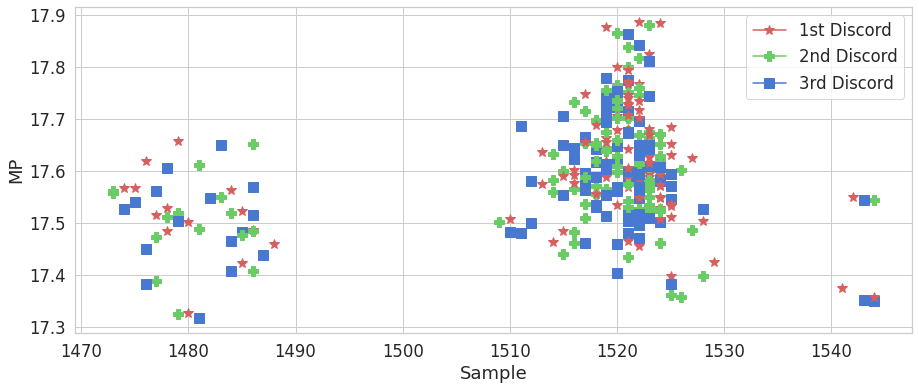

In [38]:
# Top three discords w/o exclusion zone

plt.figure(figsize=(15, 6))
for i in range(100):
#  plt.plot(profiles_d[i]["mp"])
  x1 = profiles_d[i]["discords"][0]
  y1 = profiles_d[i]['mp'][x1]
  x2 = profiles_d[i]["discords"][1]
  y2 = profiles_d[i]['mp'][x2]
  x3 = profiles_d[i]["discords"][2]
  y3 = profiles_d[i]['mp'][x3]
  plt.plot(x1, y1, marker='*', markersize=10, c='r')
  plt.plot(x2, y2, marker='P', markersize=10, c='g')
  plt.plot(x3, y3, marker='s', markersize=10, c='b')

  plt.legend(["1st Discord", "2nd Discord", "3rd Discord"])

#  plt.xlim(0, 4099)

plt.ylabel("MP"); plt.xlabel("Sample");
plt.savefig('/content/drive/MyDrive/Figures/three_discords_dorms_no-exclusion.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [39]:
# Create 100 matrix profiles with random noise
# With exclusion zone set at 100 samples

profiles_d=[]

for i in range(100):
  noise = np.random.normal(0, np.sqrt(np.mean(df_d["P1"])), df_d["P1"].shape)
  new_signal = df_d["P1"] + noise

  p = mp.compute(new_signal[::10].to_numpy(), windows=222)
  p = mp.discover.discords(p,exclusion_zone=100)
  profiles_d.append(p)

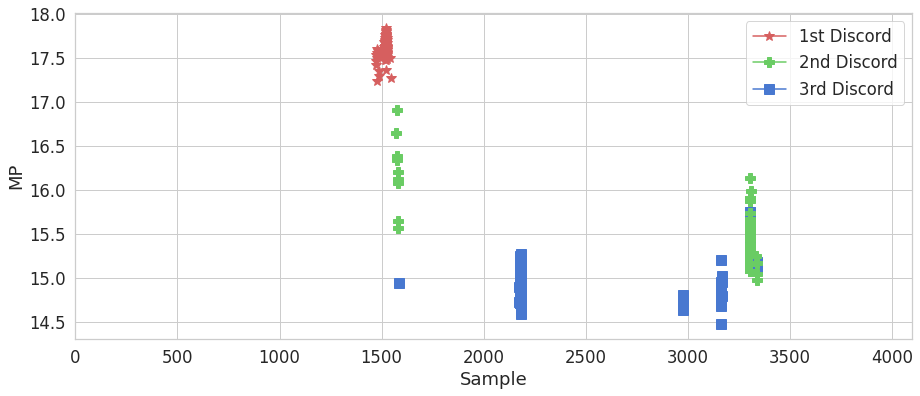

In [40]:
# Top three discords with exclusion zone

plt.figure(figsize=(15, 6))
for i in range(100):
#  plt.plot(profiles_d[i]["mp"])
  x1 = profiles_d[i]["discords"][0]
  y1 = profiles_d[i]['mp'][x1]
  x2 = profiles_d[i]["discords"][1]
  y2 = profiles_d[i]['mp'][x2]
  x3 = profiles_d[i]["discords"][2]
  y3 = profiles_d[i]['mp'][x3]
  plt.plot(x1, y1, marker='*', markersize=10, c='r')
  plt.plot(x2, y2, marker='P', markersize=10, c='g')
  plt.plot(x3, y3, marker='s', markersize=10, c='b')

  plt.legend(["1st Discord", "2nd Discord", "3rd Discord"])

  plt.xlim(0, 4099)

plt.ylabel("MP"); plt.xlabel("Sample");
plt.savefig('/content/drive/MyDrive/Figures/three_discords_dorms_exclusion.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

**PV STARTS HERE**

In [41]:
# Read PV data and convert timestamps
df_pv=pd.read_excel("drive/My Drive/Data/pv.xlsx")
df_pv["SysDate-ms"]=pd.to_datetime(df_pv["SysDate-ms"],format="%m/%d/%Y %H:%M:%S %f")

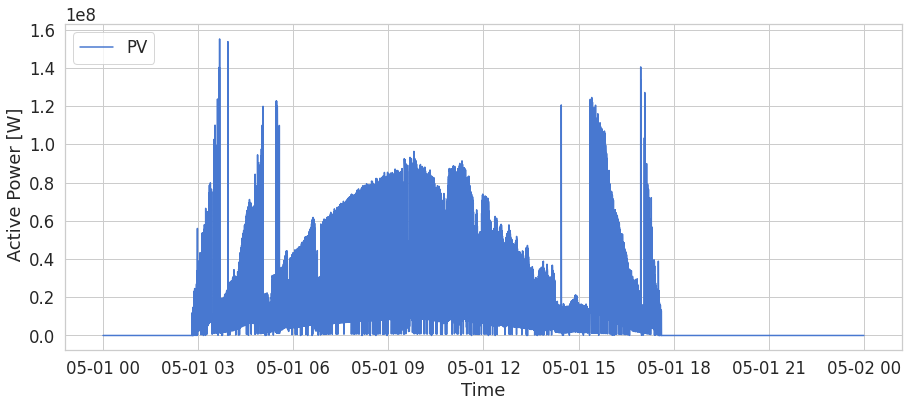

In [42]:
# Basic plot - PV

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

plt.figure(figsize=(15, 6))
plt.plot(df_pv["SysDate-ms"][::10],df_pv["ERPV_PPv"][::10], label="PV")
plt.legend(loc='upper left')
plt.ylabel(" Active Power [W]"); plt.xlabel("Time");
plt.savefig('/content/drive/MyDrive/Figures/one_day_pv.pdf', format='pdf', dpi=1000)
plt.show()

In [ ]:
# Analysis for 1s data (decimated)
profile_pv, figures_pv = mp.analyze(df_pv["ERPV_PPv"][::10].to_numpy())

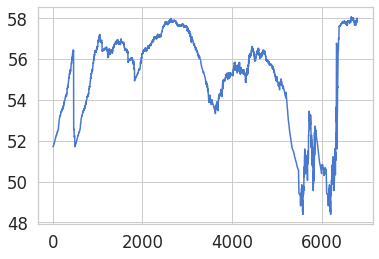

In [43]:
# Compute mp without noise
p_pv=mp.compute(df_pv["ERPV_PPv"][::10].to_numpy(), windows=1842)
plt.plot(p_pv["mp"])

In [44]:
# PV noise 0-2%
# 1%
noise = np.random.normal(0, 0.01 * (np.std(df_pv["ERPV_PPv"])), df_pv["ERPV_PPv"].shape)
new_signal = df_pv["ERPV_PPv"] + noise
p1_pv = mp.compute(new_signal[::10].to_numpy(), windows=1842)

# 2%
noise = np.random.normal(0, 0.02 * (np.std(df_pv["ERPV_PPv"])), df_pv["ERPV_PPv"].shape)
new_signal = df_pv["ERPV_PPv"] + noise
p2_pv = mp.compute(new_signal[::10].to_numpy(), windows=1842)


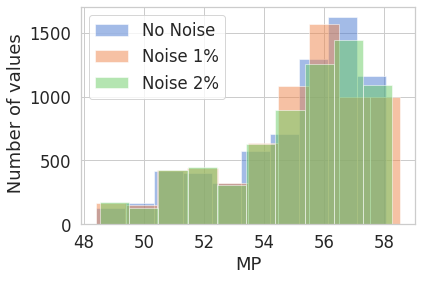

In [47]:
# MP histogram

plt.hist(p_pv['mp'],  alpha=0.5, label='No Noise')
plt.hist(p1_pv['mp'],  alpha=0.5, label='Noise 1%')
plt.hist(p2_pv['mp'], alpha=0.5, label='Noise 2%')
plt.legend(loc='upper left')
plt.ylabel(" Number of values"); plt.xlabel("MP");
plt.savefig('/content/drive/MyDrive/Figures/noisy_hist_pv.pdf',format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [48]:
# Create 100 matrix profiles with random noise
# No exclusion zone

profiles_pv=[]

for i in range(100):
  noise = np.random.normal(0, np.sqrt(np.mean(df_pv["ERPV_PPv"])), df_pv["ERPV_PPv"].shape)
  new_signal = df_pv["ERPV_PPv"] + noise

  p = mp.compute(new_signal[::10].to_numpy(), windows=1842)
  p = mp.discover.discords(p)
  profiles_pv.append(p)

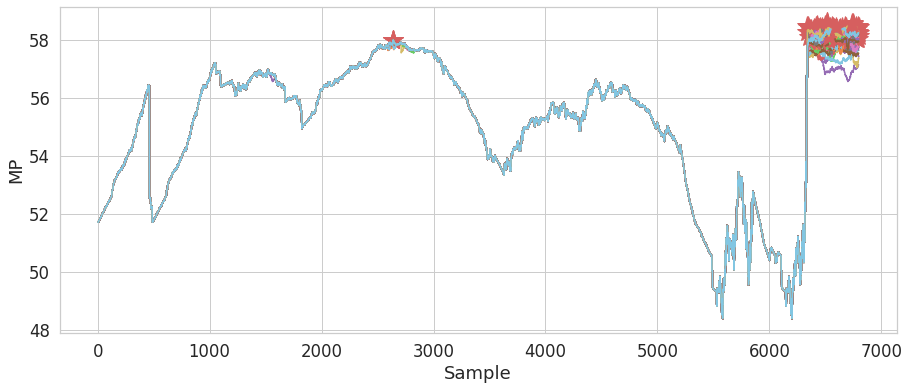

In [49]:
plt.figure(figsize=(15, 6))
for i in range(100):
  plt.plot(profiles_pv[i]["mp"])
  x = profiles_pv[i]["discords"][0]
  y = profiles_pv[i]['mp'][x]
  plt.plot(x, y, marker='*', markersize=20, c='r')

plt.ylabel("MP"); plt.xlabel("Sample");
plt.savefig('/content/drive/MyDrive/Figures/noisy_profiles_pv.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [50]:
# Basic statistics for MP without and with noise
df_pvv = pd.DataFrame()
df_pvv["MPpv"]=p_pv["mp"]

In [51]:
b=profiles_pv[0]["mp"]

for i in range(99):
  b=b+profiles_pv[i+1]["mp"]

b=b/100
df_pvv["MPpvn"]=b

In [52]:
df_pvv.describe()

,MPpv,MPpvn
count,6799.000000,6799.000000
mean,55.023353,55.061436
std,2.311061,2.337244
min,48.395639,48.395649
25%,53.716545,53.755874
50%,55.612062,55.657604
75%,56.712029,56.740510
max,58.071132,58.074532


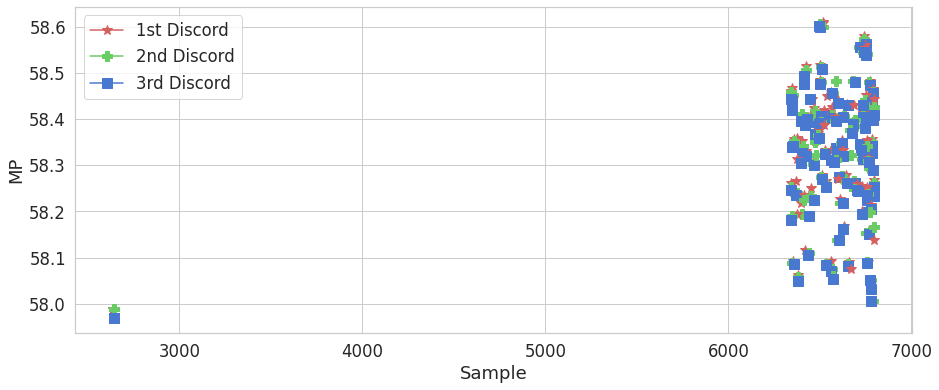

In [53]:
# Top three discords w/o exclusion zone

plt.figure(figsize=(15, 6))
for i in range(100):
#  plt.plot(profiles_d[i]["mp"])
  x1 = profiles_pv[i]["discords"][0]
  y1 = profiles_pv[i]['mp'][x1]
  x2 = profiles_pv[i]["discords"][1]
  y2 = profiles_pv[i]['mp'][x2]
  x3 = profiles_pv[i]["discords"][2]
  y3 = profiles_pv[i]['mp'][x3]
  plt.plot(x1, y1, marker='*', markersize=10, c='r')
  plt.plot(x2, y2, marker='P', markersize=10, c='g')
  plt.plot(x3, y3, marker='s', markersize=10, c='b')

  plt.legend(["1st Discord", "2nd Discord", "3rd Discord"])

#  plt.xlim(0, 4099)

plt.ylabel("MP"); plt.xlabel("Sample");
plt.savefig('/content/drive/MyDrive/Figures/three_discords_pv_no-exclusion.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()

In [58]:
# Create 100 matrix profiles with random noise
# With exclusion zone

profiles_pv=[]

for i in range(100):
  noise = np.random.normal(0, np.sqrt(np.mean(df_pv["ERPV_PPv"])), df_pv["ERPV_PPv"].shape)
  new_signal = df_pv["ERPV_PPv"] + noise

  p = mp.compute(new_signal[::10].to_numpy(), windows=1842)
  p = mp.discover.discords(p, exclusion_zone=600)
  profiles_pv.append(p)

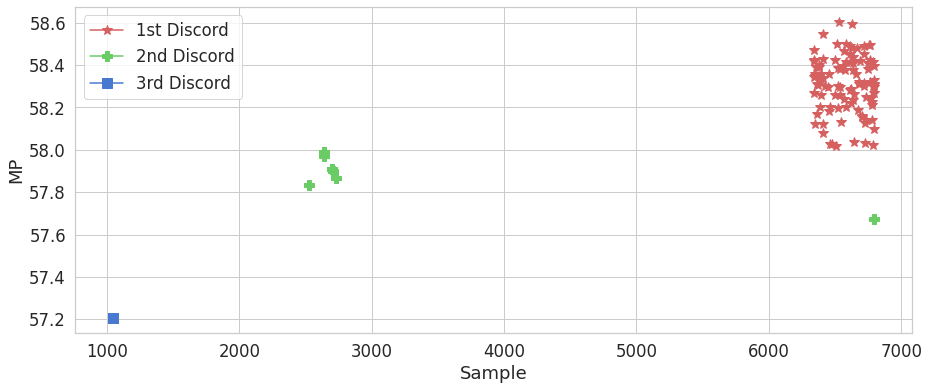

In [59]:
# Top three discords with exclusion zone

plt.figure(figsize=(15, 6))
for i in range(100):
#  plt.plot(profiles_d[i]["mp"])
  x1 = profiles_pv[i]["discords"][0]
  y1 = profiles_pv[i]['mp'][x1]
  x2 = profiles_pv[i]["discords"][1]
  y2 = profiles_pv[i]['mp'][x2]
  x3 = profiles_pv[i]["discords"][2]
  y3 = profiles_pv[i]['mp'][x3]
  plt.plot(x1, y1, marker='*', markersize=10, c='r')
  plt.plot(x2, y2, marker='P', markersize=10, c='g')
  plt.plot(x3, y3, marker='s', markersize=10, c='b')

  plt.legend(["1st Discord", "2nd Discord", "3rd Discord"])

#  plt.xlim(0, 4099)

plt.ylabel("MP"); plt.xlabel("Sample");
plt.savefig('/content/drive/MyDrive/Figures/three_discords_pv_exclusion.pdf', format='pdf', dpi=1000, bbox_inches='tight')
plt.show()